<a href="https://colab.research.google.com/github/SergiyDovgopolyk/Data_Science/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    return x3

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    acc_met = tf.metrics.Accuracy()
    acc_met.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc_met.result()

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    trainable_variables  = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradient = g.gradient(loss, trainable_variables)
    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradient, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accurancy = accuracy(pred, batch_y)
        accuracy_history.append(current_accurancy)
        print(f'Step - {step} || Accurancy at this step - {current_accurancy} || Loss at this step - {current_loss}')

Step - 100 || Accurancy at this step - 0.68359375 || Loss at this step - 287.73443603515625
Step - 200 || Accurancy at this step - 0.765625 || Loss at this step - 202.6865692138672
Step - 300 || Accurancy at this step - 0.8203125 || Loss at this step - 168.12489318847656
Step - 400 || Accurancy at this step - 0.8125 || Loss at this step - 147.6005859375
Step - 500 || Accurancy at this step - 0.81640625 || Loss at this step - 153.43350219726562
Step - 600 || Accurancy at this step - 0.80859375 || Loss at this step - 165.3677215576172
Step - 700 || Accurancy at this step - 0.8984375 || Loss at this step - 109.82977294921875
Step - 800 || Accurancy at this step - 0.8828125 || Loss at this step - 113.83035278320312
Step - 900 || Accurancy at this step - 0.87109375 || Loss at this step - 102.2779541015625
Step - 1000 || Accurancy at this step - 0.87890625 || Loss at this step - 113.66342163085938
Step - 1100 || Accurancy at this step - 0.91015625 || Loss at this step - 98.7030258178711
Step

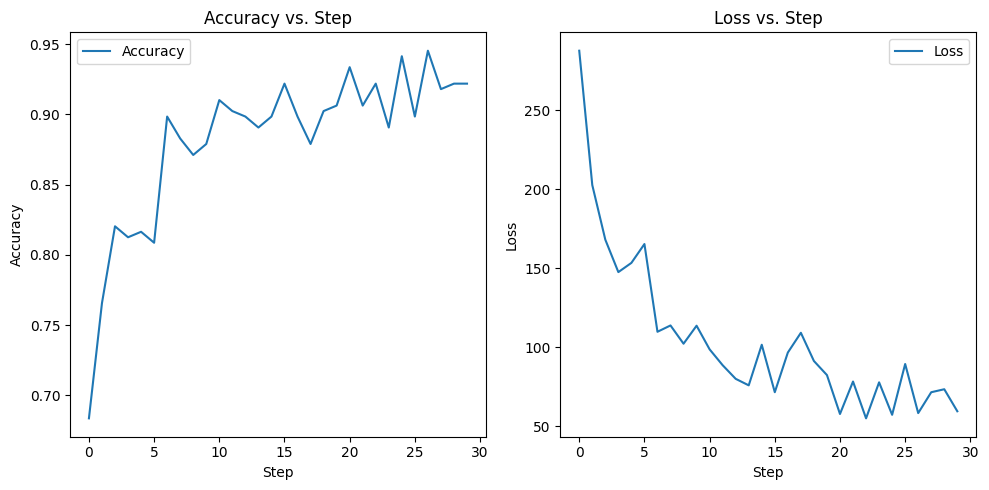

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Step')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Step')
plt.legend()

plt.tight_layout()
plt.show()
# Виведіть графік точності
# Місце для вашого коду


In [10]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
nn_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {nn_accuracy}")
# Тестування моделі на тестових даних
# Місце для вашого коду
# Підготовка тестового датасету
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Функція для тестування моделі
def test(neural_net, test_data):
    test_accuracy_aggregator = []
    for (batch_x, batch_y) in test_data:
        prediction = neural_net(batch_x)
        test_accuracy = accuracy(prediction, batch_y)
        test_accuracy_aggregator.append(test_accuracy)
    return np.mean(test_accuracy_aggregator)

# Тестування моделі
test_accuracy = test(neural_net, test_data)
print(f'Test Accuracy: {test_accuracy}')

Accuracy: 0.9183333516120911
Test Accuracy: 0.9032226800918579


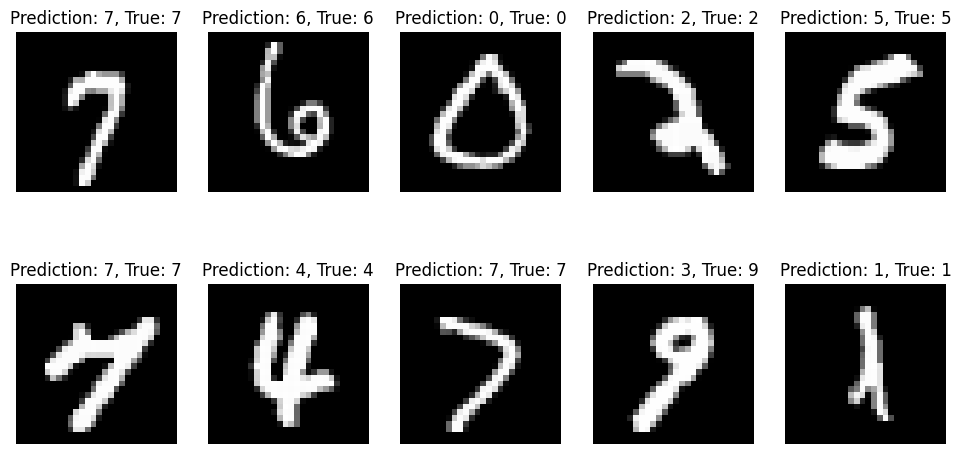

Error rate: 0.1, Incorrect predictions: 1


In [15]:

# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {pred_data[i]}, True: {y_test_true[i]}')
    plt.axis('off')

plt.show()

incorrect_predictions = np.sum(np.array(pred_data) != y_test_true)
error_rate = incorrect_predictions / 10
print(f'Error rate: {error_rate}, Incorrect predictions: {incorrect_predictions}')


In [ ]:
# Висновок

# Моя нейронна мережа інколи помиляється, але Error rate не перевищує 0,1, тобто 10%. Вважаю це досить непоганим результатом)